# Fire Classifier V1


First attempt for the fire classification task
Adapted from Keras example: https://www.tensorflow.org/tutorials/images/cnn


### Imports

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np


from PIL import Image
from PIL import ImageOps


### Import Data

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Already unzipped in ML project dir
# !unzip /content/gdrive/MyDrive/ML/ML_Project/Training.zip -d /content/gdrive/MyDrive/ML/ML_Project
# !ls

import glob

path = "/content/gdrive/MyDrive/ML/ML_Project/"
fireTrain = np.array(glob.glob(path + "Training/Fire/*.jpg", recursive = True))
print("Fire train shape", np.shape(fireTrain))
nofireTrain = np.array(glob.glob(path + "Training/No_Fire/*.jpg", recursive = True))
print("No fire train shape", np.shape(nofireTrain))

labelsFire = np.ones(np.shape(fireTrain)[0])
labelsNofire = np.zeros(np.shape(nofireTrain)[0])

files = np.concatenate((fireTrain, nofireTrain), axis=0)
labels = np.concatenate((labelsFire, labelsNofire), axis=0)
print("Files Shape", np.shape(files))
print("Labels Shape", np.shape(labels))


Fire train shape (25018,)
No fire train shape (14357,)
Files Shape (39375,)
Labels Shape (39375,)


### Seperate the data into train and validation

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(
    files, labels, test_size=0.2, random_state=21
)

### Prepare the Data Generator

Adapted from: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly


In [ ]:
# (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# # Normalize pixel values to be between 0 and 1
# train_images, test_images = train_images / 255.0, test_images / 255.0

# ---------------

# Data Generator

from tensorflow import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, labels, batch_size=32, dim=(254, 254), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # X[i,] = np.load('data/' + ID + '.npy')
            image = Image.open(ID)
            # imageGrey = ImageOps.grayscale(image)
            # imageGreyArray = np.array(imageGrey)
            imageArray = np.array(image)
            imageArrayNorm = imageArray.astype('float32') / 255
            X[i,] = imageArrayNorm

            # Store class
            y[i] = 0
            if ("/Fire" in ID):
              y[i] = 1

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)



### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


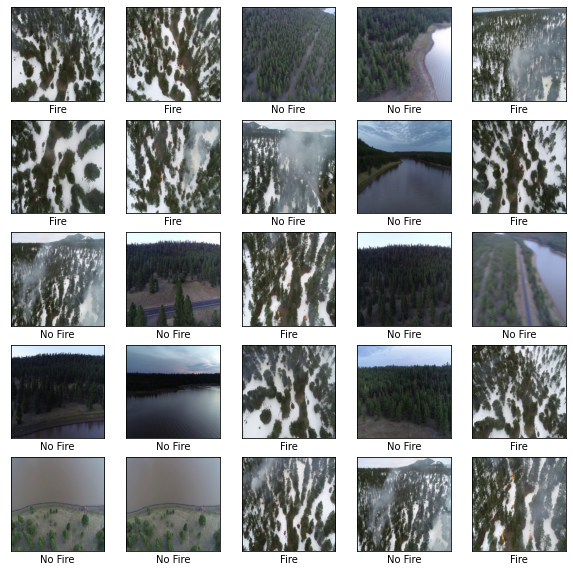

In [ ]:
class_names = ['No Fire', 'Fire']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(Image.open(train_data[i]))
    plt.xlabel(class_names[int(train_labels[i])])
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(254, 254, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# batch normailzation
# Leaky relu 
model.add(layers.MaxPooling2D((2, 2)))


Model architecture so far:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-traina

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

Here's the complete architecture of your model:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 230400)            0

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [ ]:


params = {'dim': (254, 254),
            'batch_size': 100,
            'n_channels': 3,
            'shuffle': True}

training_generator = DataGenerator(train_data, train_labels, **params)
validation_generator = DataGenerator(files, files, **params)

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])


history = model.fit(training_generator, validation_data=validation_generator, epochs=10)

# history = model.fit(train_images, train_labels, epochs=10, 
#                     validation_data=(test_images, test_labels))

Epoch 1/10
315/315 [==============================] - ETA: 0s - loss: 4.5694 - accuracy: 0.9336 

### Evaluate the model

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


In [ ]:
fireTest = np.array(glob.glob(path + "Test/Fire/*.jpg", recursive = True))
print("Fire test shape", np.shape(fireTest))
nofireTest = np.array(glob.glob(path + "Test/No_Fire/*.jpg", recursive = True))
print("No fire test shape", np.shape(nofireTest))

labelsFireTest = np.ones(np.shape(fireTest)[0])
labelsNofireTest = np.zeros(np.shape(nofireTest)[0])

filesTest = np.concatenate((fireTest, nofireTest), axis=0)
labelsTest = np.concatenate((labelsFireTest, labelsNofireTest), axis=0)
print("Files Test Shape", np.shape(filesTest))
print("Labels Test Shape", np.shape(labelsTest))

test_images = np.empty((np.shape(filesTest)[0], 254, 254, 3))

for idx, testImage in enumerate(filesTest):
  image = Image.open(testImage)
  imageArray = np.array(image)
  imageArrayNorm = imageArray.astype('float32') / 255
  test_images[idx,] = imageArrayNorm
  
  
test_loss, test_acc = model.evaluate(test_images,  labelsTest, verbose=2)

print(test_acc)